# 07 自动求导
深度学习框架通过自动计算导数，即*自动微分*（automatic differentiation）来加快求导。
实际中，根据我们设计的模型，系统会构建一个*计算图*（computational graph），*计算图*是一个有向无环图（DAG），
来跟踪计算是哪些数据通过哪些操作组合起来产生输出。
自动微分使系统能够随后反向传播梯度。
这里，*反向传播*（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

### 反向传播复杂度
计算复杂度O(n),n是操作子个数
- 通常正向和反向的代价类似
内存复杂度O(n)，因为需要存储正向的所有中间结果
### 正向累积复杂度
O(n)计算复杂度用来计算一个变量的梯度
O(1)内存复杂度

## 一个简单的例子

作为一个演示例子，(**假设我们想对函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于列向量$\mathbf{x}$求导**)。
首先，我们创建变量`x`并为其分配一个初始值。


In [1]:
import torch
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [2]:
x.requires_grad_(True)
x.grad

In [3]:
y = 2 * torch.dot(x, x)#隐式构造了计算图
y

tensor(28., grad_fn=<MulBackward0>)

In [4]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [5]:
x.grad == 4 * x

tensor([True, True, True, True])

In [7]:
# 在默认状况下，Pytorch会将累计梯度，因此需要清除之前的值，
# 带有下划线的函数：在pytorch中，我们需要注意，对于tensor的操作时候是in-place类型。
# in-place类型是指，但在一个tensor上操作了之后，是直接修改了这个tensor，还是返回一个新的tensor，而旧的tensor并不修改。
# pytorch中，一般来说，如果对tensor的一个函数后加上了下划线，则表明这是一个in-place类型
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [8]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 在我们的例子中，我们只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [9]:
x.grad.zero_()
y = x * x 
# 返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置,不同之处只是requires_grad为false，得到的这个tensor永远不需要计算其梯度，不具有grad。
# 分离y来返回一个新变量u，该变量与y具有相同的值， 但丢弃计算图中如何计算y的任何信息。 换句话说，梯度不会向后流经u到x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [10]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

即使构建函数的计算图需要通过Python控制流（eg，条件、循环、或任意函数调用）我们仍然可以计算得到的变量的梯度

In [12]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

a.grad == d / a

tensor(True)

## 练习

1. 为什么计算二阶导数比一阶导数的开销要更大？
1. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。
1. 在控制流的例子中，我们计算`d`关于`a`的导数，如果我们将变量`a`更改为随机向量或矩阵，会发生什么？
1. 重新设计一个求控制流梯度的例子，运行并分析结果。
1. 使$f(x)=\sin(x)$，绘制$f(x)$和$\frac{df(x)}{dx}$的图像，其中后者不使用$f'(x)=\cos(x)$。


Q1:计算二阶导数是在一阶导数的基础上进行的，自然开销要大。

Q2

In [8]:
%reset
import torch
x = torch.randn(size=(3, 6), requires_grad=True)
t = torch.randn(size=(6, 4), requires_grad=True)
y = 2 * torch.mm(x, t)
y.sum().backward()
x.grad
t.grad

Nothing done.


tensor([[ -4.8503,  -4.8503,  -4.8503,  -4.8503],
        [  3.0787,   3.0787,   3.0787,   3.0787],
        [  3.3654,   3.3654,   3.3654,   3.3654],
        [ -8.3057,  -8.3057,  -8.3057,  -8.3057],
        [-10.5088, -10.5088, -10.5088, -10.5088],
        [  1.4539,   1.4539,   1.4539,   1.4539]])

Q4

In [15]:
%reset
def f(a):
    b = a + abs(a)
    c = b - b ** (-4)
    return c

a = torch.randn(size=(3,1), requires_grad=True)
print(a.shape)
print(a)
d = f(a)
d.sum().backward()
print(a.grad)

Nothing done.
torch.Size([3, 1])
tensor([[-0.5790],
        [ 1.1411],
        [ 0.9706]], requires_grad=True)
tensor([[   nan],
        [2.1292],
        [2.2902]])


Q5

Nothing done.


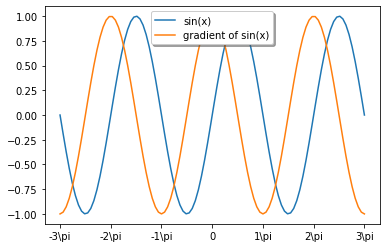

In [12]:
%reset
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import numpy as np
import torch

f,ax=plt.subplots(1)

x = np.linspace(-3*np.pi, 3*np.pi, 100)
x1= torch.tensor(x, requires_grad=True)
y1= torch.sin(x1)
y1.sum().backward()

ax.plot(x,np.sin(x),label='sin(x)')
ax.plot(x,x1.grad,label="gradient of sin(x)")
ax.legend(loc='upper center', shadow=True)

ax.xaxis.set_major_formatter(FuncFormatter(
lambda val,pos: '{:.0g}\pi'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))

plt.show()